<a href="https://colab.research.google.com/github/sophiakarski/DBpython/blob/master/SIR_Poj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import pandas
import numpy as np

In [ ]:
county_cases_data = pandas.read_csv("https://rajstorage11.blob.core.windows.net/test/us-counties.csv")
unemployment_data = pandas.read_csv("https://rajstorage11.blob.core.windows.net/test/Unemployment.csv", index_col="FIPStxt")
county_area_data = pandas.read_csv("https://rajstorage11.blob.core.windows.net/test/Counties.csv", index_col="GEOID")
population_data = pandas.read_csv("https://rajstorage11.blob.core.windows.net/test/PopulationEstimates.csv", index_col="FIPStxt", encoding='latin-1')

In [ ]:
county_cases_data.head()
#print(unemployment_data.count())

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [ ]:
unemployment_data.head()
#print(unemployment_data.count())

,Stabr,area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,Civilian_labor_force_2001,Employed_2001,Unemployed_2001,Unemployment_rate_2001,Civilian_labor_force_2002,Employed_2002,Unemployed_2002,Unemployment_rate_2002,Civilian_labor_force_2003,Employed_2003,Unemployed_2003,Unemployment_rate_2003,Civilian_labor_force_2004,Employed_2004,Unemployed_2004,Unemployment_rate_2004,Civilian_labor_force_2005,Employed_2005,Unemployed_2005,Unemployment_rate_2005,Civilian_labor_force_2006,Employed_2006,Unemployed_2006,Unemployment_rate_2006,Civilian_labor_force_2007,Employed_2007,Unemployed_2007,Unemployment_rate_2007,Civilian_labor_force_2008,Employed_2008,Unemployed_2008,...,Unemployed_2010,Unemployment_rate_2010,Civilian_labor_force_2011,Employed_2011,Unemployed_2011,Unemployment_rate_2011,Civilian_labor_force_2012,Employed_2012,Unemployed_2012,Unemployment_rate_2012,Civilian_labor_force_2013,Employed_2013,Unemployed_2013,Unemployment_rate_2013,Civilian_labor_force_2014,Employed_2014,Unemployed_2014,Unemployment_rate_2014,Civilian_labor_force_2015,Employed_2015,Unemployed_2015,Unemployment_rate_2015,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,Civilian_labor_force_2017,Employed_2017,Unemployed_2017,Unemployment_rate_2017,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
FIPStxt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,US,United States,NaN,NaN,NaN,"142,601,667","136,904,680","5,696,987",4.0,"143,786,778","136,978,129","6,808,649",4.7,"144,839,532","136,455,911","8,383,621",5.8,"145,660,181","136,944,540","8,715,641",6.0,"146,725,005","138,614,038","8,110,967",5.5,"148,012,786","140,462,401","7,550,385",5.1,"150,223,730","143,262,292","6,961,438",4.6,"152,191,286","145,156,247","7,035,039",4.6,"153,761,298","144,860,522","8,900,776",...,"14,862,528",9.6,"154,606,324","140,765,822","13,840,502",9.0,"155,119,209","142,600,412","12,518,797",8.1,"155,485,689","144,018,150","11,467,539",7.4,"155,957,310","146,338,323","9,618,987",6.2,"156,798,981","148,515,185","8,283,796",5.0,"158,626,135","150,902,618","7,723,517",4.9,"160,158,564","153,183,461","6,975,103",4.4,"161,389,026","155,102,319","6,286,707",3.9,"163,100,055","157,115,247","5,984,808",3.7,"61,937",NaN
1000,AL,Alabama,NaN,NaN,NaN,"2,133,223","2,035,594","97,629",4.6,"2,115,401","2,006,884","108,517",5.1,"2,106,161","1,981,919","124,242",5.9,"2,120,225","1,992,732","127,493",6.0,"2,136,458","2,014,889","121,569",5.7,"2,146,025","2,049,791","96,234",4.5,"2,167,809","2,080,233","87,576",4.0,"2,175,612","2,089,127","86,485",4.0,"2,176,489","2,053,477","123,012",...,"231,483",10.5,"2,202,670","1,990,413","212,257",9.6,"2,176,337","2,003,290","173,047",8.0,"2,174,000","2,017,043","156,957",7.2,"2,160,842","2,014,290","146,552",6.8,"2,161,481","2,030,005","131,476",6.0,"2,182,558","2,055,251","127,307",5.8,"2,186,869","2,090,373","96,496",4.4,"2,216,627","2,130,845","85,782",3.9,"2,241,747","2,174,483","67,264",3.0,"49,881",100.0
1001,AL,"Autauga County, AL",2.0,2.0,1.0,"21,720","20,846",874,4.0,"21,955","21,055",900,4.1,"22,094","21,035","1,059",4.8,"22,604","21,462","1,142",5.1,"23,218","22,103","1,115",4.8,"23,949","23,037",912,3.8,"24,398","23,585",813,3.3,"24,383","23,577",806,3.3,"24,687","23,420","1,267",...,"2,282",8.9,"25,836","23,677","2,159",8.4,"25,740","23,961","1,779",6.9,"25,810","24,205","1,605",6.2,"25,592","24,097","1,495",5.8,"25,652","24,321","1,331",5.0,"26,031","24,709","1,322",5.1,"26,075","25,062","1,013",3.9,"26,196","25,261",935,3.6,"26,172","25,458",714,2.7,"59,338",119.0
1003,AL,"Baldwin County, AL",3.0,2.0,1.0,"69,533","66,971","2,562",3.7,"69,161","66,195","2,966",4.3,"69,169","65,691","3,478",5.0,"72,299","

In [ ]:
        fips_case_start = county_cases_data.reset_index()
fips_case_start = fips_case_start[fips_case_start["cases"] > 0].groupby("fips").min().rename(columns={"date": "day0"})
fips_case_start["day0"] = fips_case_start["day0"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
fips_case_start.head()

,index,day0,county,state,cases,deaths
fips,,,,,,
1001.0,9480,2020-03-24,Autauga,Alabama,1,0
1003.0,1934,2020-03-14,Baldwin,Alabama,1,0
1005.0,28389,2020-04-03,Barbour,Alabama,1,0
1007.0,19658,2020-03-30,Bibb,Alabama,2,0
1009.0,10834,2020-03-25,Blount,Alabama,1,0


In [ ]:
fips_case_history = county_cases_data[["date", "fips", "county", "state", "cases", "deaths"]]
#print(unemployment_data.head())
print(fips_case_history.head())
print(unemployment_data.loc[[53061]][["Median_Household_Income_2018"]])

         date     fips     county       state  cases  deaths
0  2020-01-21  53061.0  Snohomish  Washington      1       0
1  2020-01-22  53061.0  Snohomish  Washington      1       0
2  2020-01-23  53061.0  Snohomish  Washington      1       0
3  2020-01-24  17031.0       Cook    Illinois      1       0
4  2020-01-24  53061.0  Snohomish  Washington      1       0
        Median_Household_Income_2018
FIPStxt                             
53061                         87,096


In [ ]:
fips_case_history = fips_case_history.join(unemployment_data[["Median_Household_Income_2018"]].rename(columns={"Median_Household_Income_2018": "household_income"}), how="inner", on="fips") #With the ID of unemployment data that is FIPStxt
print(fips_case_history.head())
fips_case_history = fips_case_history.join(fips_case_start[["day0"]], how="inner", on="fips")
fips_case_history["date"] = fips_case_history["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
fips_case_history["days_spreading"] = fips_case_history["date"] - fips_case_history["day0"]
fips_case_history["days_spreading"] = fips_case_history["days_spreading"].apply(lambda x: x.days)
fips_case_history["household_income"] = fips_case_history["household_income"].apply(lambda x: int(x.replace(",","")))

fips_case_history.head()


         date     fips     county       state  cases  deaths household_income
0  2020-01-21  53061.0  Snohomish  Washington      1       0           87,096
1  2020-01-22  53061.0  Snohomish  Washington      1       0           87,096
2  2020-01-23  53061.0  Snohomish  Washington      1       0           87,096
4  2020-01-24  53061.0  Snohomish  Washington      1       0           87,096
7  2020-01-25  53061.0  Snohomish  Washington      1       0           87,096


,date,fips,county,state,cases,deaths,household_income,day0,days_spreading
0,2020-01-21,53061.0,Snohomish,Washington,1,0,87096,2020-01-21,0
1,2020-01-22,53061.0,Snohomish,Washington,1,0,87096,2020-01-21,1
2,2020-01-23,53061.0,Snohomish,Washington,1,0,87096,2020-01-21,2
4,2020-01-24,53061.0,Snohomish,Washington,1,0,87096,2020-01-21,3
7,2020-01-25,53061.0,Snohomish,Washington,1,0,87096,2020-01-21,4


In [ ]:
fips_ind = fips_case_history[["date","fips","county","state","cases","deaths","days_spreading"]]
fips_ind = fips_ind.groupby("fips").filter(lambda x : len(x)>50)
#fips_ind = fips_ind.groupby('fips').agg('count')
#fips_ind.head()
Uniquefips = fips_ind.fips.unique()
DataFrameDict = {elem : pandas.DataFrame for elem in Uniquefips}
for key in DataFrameDict.keys():
    DataFrameDict[key] = fips_ind[:][fips_ind.fips == key]
#len(DataFrameDict[1001])
DataFrameDict[1001].iloc[[-1]][["days_spreading"]]

,days_spreading
221644,78


In [ ]:
from scipy.integrate import odeint
#import matplotlib.pyplot as plt
import numpy as np
#a = DataFrameDict[1001].iloc[[-1]][["cases"]].astype(int)
#print(a.values[0][0])
# Total population, N.
for key in DataFrameDict.keys():
  N = DataFrameDict[key].iloc[[-1]][["cases"]].astype(int).values[0][0]
  I0, R0 = 1, 0
  S0 = N - I0 - R0
  beta = 0.142 
  gamma = 0.056
  t = np.linspace(0, DataFrameDict[key].shape[0]+1, DataFrameDict[key].shape[0]+1)

  def deriv(y, t, N, beta, gamma):
      S, I, R = y
      dSdt = -beta * S * I / N
      dIdt = beta * S * I / N - gamma * I
      dRdt = gamma * I
      return dSdt, dIdt, dRdt

  y0 = S0, I0, R0
  ret = odeint(deriv, y0, t, args=(N, beta, gamma))
  S, I, R = ret.T

  #length = np.random.random(10)
  #length.sort()
  #time = np.random.random(10)
  #time.sort()
  #slope, intercept = np.polyfit(I, t, 1)
  #s1 = slope
  s2 = np.diff(I)/np.diff(t)
  s3 = s2*s2
  s2=(s2+2)/2
  DataFrameDict[key]['estimated_r1_SIR'] = s2
  DataFrameDict[key]['estimated_r2_SIR'] = s3
  #DataFrameDict[key]
#print(s1
#plt.loglog(length, time, '--')
#plt.show()

  #fig = plt.figure(facecolor='w')
  #ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
  #ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
  #ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
  #ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
  #ax.set_xlabel('Time /days')
  #ax.set_ylabel('Number (1000s)')
  #ax.set_ylim(0,0.5)
  #ax.yaxis.set_tick_params(length=0)
  #ax.xaxis.set_tick_params(length=0)
  #ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  #legend = ax.legend()
  #legend.get_frame().set_alpha(0.5)
  #for spine in ('top', 'right', 'bottom', 'left'):
   #   ax.spines[spine].set_visible(False)
  ##plt.show()
#print("Hi")

In [ ]:
for key in DataFrameDict.keys():
  #DataFrameDict[key]["new_date"] = DataFrameDict[key]["date"].apply(lambda x: x+timedelta(days=1))
  DataFrameDict[key]["prev_day_cases"] = DataFrameDict[key]["cases"].shift(1)
  #del DataFrameDict[key]['new_date']
  DataFrameDict[key].fillna(0,inplace = True)

In [ ]:
DataFrameDict[1003]

,date,fips,county,state,cases,deaths,days_spreading,estimated_r1_SIR,estimated_r2_SIR,prev_day_cases
1934,2020-03-14,1003.0,Baldwin,Alabama,1,0,0,1.044685,0.007987,0.0
2309,2020-03-15,1003.0,Baldwin,Alabama,1,0,1,1.048685,0.009481,1.0
2738,2020-03-16,1003.0,Baldwin,Alabama,1,0,2,1.053036,0.011251,1.0
3214,2020-03-17,1003.0,Baldwin,Alabama,1,0,3,1.057768,0.013348,1.0
3760,2020-03-18,1003.0,Baldwin,Alabama,1,0,4,1.062911,0.015831,1.0
...,...,...,...,...,...,...,...,...,...,...
209600,2020-06-06,1003.0,Baldwin,Alabama,320,9,84,0.312755,1.889222,312.0
212607,2020-06-07,1003.0,Baldwin,Alabama,329,9,85,0.286922,2.033919,320.0
215617,2020-06-08,1003.0,Baldwin,Alabama,335,9,86,0.265016,2.160804,329.0
218629,2020-06-09,1003.0,Baldwin,Alabama,340,9,87,0.246837,2.269020,335.0


In [ ]:
for key in DataFrameDict.keys():
  s = DataFrameDict[key]["cases"]/(DataFrameDict[key]["prev_day_cases"]+1)
  DataFrameDict[key]["estimated_r3"] = s
  #DataFrameDict[key].replace(np.inf, np.nan)
  #DataFrameDict[key].fillna(1,inplace = True)

In [ ]:
DataFrameDict[1001]

,date,fips,county,state,cases,deaths,days_spreading,estimated_r1_SIR,estimated_r2_SIR,prev_day_cases,estimated_r3
9480,2020-03-24,1001.0,Autauga,Alabama,1,0,0,1.044647,0.007973,0.0,1.000000
10832,2020-03-25,1001.0,Autauga,Alabama,4,0,1,1.048640,0.009463,1.0,2.000000
12361,2020-03-26,1001.0,Autauga,Alabama,6,0,2,1.052981,0.011228,4.0,1.200000
14021,2020-03-27,1001.0,Autauga,Alabama,6,0,3,1.057700,0.013317,6.0,0.857143
15801,2020-03-28,1001.0,Autauga,Alabama,6,0,4,1.062827,0.015789,6.0,0.857143
...,...,...,...,...,...,...,...,...,...,...,...
209599,2020-06-06,1001.0,Autauga,Alabama,260,5,74,0.726905,0.298323,249.0,1.040000
212606,2020-06-07,1001.0,Autauga,Alabama,266,5,75,0.673983,0.425148,260.0,1.019157
215616,2020-06-08,1001.0,Autauga,Alabama,273,5,76,0.624911,0.562766,266.0,1.022472
218628,2020-06-09,1001.0,Autauga,Alabama,283,5,77,0.579770,0.706374,273.0,1.032847


In [ ]:
list1 = []
for key in DataFrameDict.keys():
  list1.append(DataFrameDict[key]['estimated_r1_SIR'].max())

In [ ]:
list1.sort()
print(list1)

[0.9984334288482252, 0.9984334288482252, 0.9985994447194807, 0.9985994447194807, 0.9986757340733036, 0.9986757340733036, 0.9987478674324617, 0.9988160710443338, 0.9988805580673881, 0.9989991862313886, 0.9989991862313886, 0.9990536986975345, 0.9991052414065853, 0.9991052414065853, 0.9991539772237872, 0.9992436288931683, 0.9992848265409429, 0.9992848265409429, 0.9992848265409429, 0.9992848265409429, 0.9993606114905177, 0.9993606114905177, 0.9993954368105226, 0.9993954368105226, 0.9993954368105226, 0.9993954368105226, 0.9994283652832006, 0.9994283652832006, 0.9994595001908996, 0.9995167748219, 0.9995167748219, 0.9995167748219, 0.9995430941380002, 0.9995679798032531, 0.9995915101180174, 0.9995915101180174, 0.999613758750663, 0.9996347954776635, 0.9996347954776635, 0.9996546864942605, 0.9996546864942605, 0.9996546864942605, 0.9996546864942605, 0.9996734941119226, 0.9997390234094133, 0.9998332657717433, 1.0062796714114899, 1.0062801192602133, 1.006280550211955, 1.006280965205278, 1.006281750

In [ ]:
for key in DataFrameDict.keys():
  #DataFrameDict[key]["new_date"] = DataFrameDict[key]["date"].apply(lambda x: x+timedelta(days=1))
  DataFrameDict[key]["prev_day_cases"] = DataFrameDict[key]["cases"].shift(1)
  #del DataFrameDict[key]['new_date']
  DataFrameDict[key].fillna(0,inplace = True)
  s = DataFrameDict[key]["cases"]/(DataFrameDict[key]["prev_day_cases"]+1)
  DataFrameDict[key]["estimated_r3"] = s

In [ ]:
fips_r_base = fips_case_history.copy()
fips_r_base["date_delta"] = fips_r_base["date"].apply(lambda x: x+timedelta(days=10))
#fips_r_base.head()
#functio
#fips_r_base["date_delta"] = fips_r_base["date"].apply
fips_r1 = fips_r_base[["fips", "date", "cases", "county", "state"]].set_index(["fips", "date"], verify_integrity=True)

In [ ]:
fips_r2 = fips_r_base[["fips", "date", "date_delta", "cases"]]
fips_r2 = fips_r2.rename(columns={"date": "from_date", "date_delta": "date", "cases": "past_cases"}).set_index(["fips", "date"])
print(fips_r2.head())


                    from_date  past_cases
fips    date                             
53061.0 2020-01-31 2020-01-21           1
        2020-02-01 2020-01-22           1
        2020-02-02 2020-01-23           1
        2020-02-03 2020-01-24           1
        2020-02-04 2020-01-25           1


In [ ]:
fips_r = fips_r1.join(fips_r2, on=["fips", "date"], how="inner")
fips_r.head()


cases     county       state  from_date  past_cases
fips    date                                                           
53061.0 2020-01-31      1  Snohomish  Washington 2020-01-21           1
        2020-02-01      1  Snohomish  Washington 2020-01-22           1
        2020-02-02      1  Snohomish  Washington 2020-01-23           1
        2020-02-03      1  Snohomish  Washington 2020-01-24           1
        2020-02-04      1  Snohomish  Washington 2020-01-25           1

In [ ]:
fips_r["case_delta"] = fips_r["cases"] - fips_r["past_cases"]
fips_r["estimated_r"] = fips_r["cases"]/ fips_r["past_cases"]
#fips_r["estimated_r"] = fips_r['case_delta']
fips_r.index.rename(["fips","date"], inplace=True)
fips_r.head()
#fips_r.loc[[1001]].head()


cases     county  ... case_delta estimated_r
fips    date                          ...                       
53061.0 2020-01-31      1  Snohomish  ...          0         1.0
        2020-02-01      1  Snohomish  ...          0         1.0
        2020-02-02      1  Snohomish  ...          0         1.0
        2020-02-03      1  Snohomish  ...          0         1.0
        2020-02-04      1  Snohomish  ...          0         1.0

[5 rows x 7 columns]

In [ ]:
population_density = population_data[["POP_ESTIMATE_2019"]]
#print(population_density.head())
#print(county_area_data.loc[[1001]])
population_density = population_density.join(county_area_data[["Shape.STArea()"]]).dropna()
#print(population_density.head()) #Joining on basis of index of both
population_density["POP_ESTIMATE_2019"] = population_density["POP_ESTIMATE_2019"].apply(lambda x: int(x.replace(",","")))
population_density["population_density"] = population_density["POP_ESTIMATE_2019"]/(population_density["Shape.STArea()"]/1000000)
population_density.head()

,POP_ESTIMATE_2019,Shape.STArea(),population_density
FIPStxt,,,
1001,55869,2.208657e+09,25.295462
1003,223234,5.908822e+09,37.779782
1005,24686,3.257905e+09,7.577262
1007,22394,2.311989e+09,9.686033
1009,57826,2.456903e+09,23.536137


In [ ]:
fips_final = fips_case_history[["date", "fips", "cases", "household_income", "days_spreading"]]
fips_final = fips_final.join(population_density[["population_density"]], on="fips").set_index(["fips","date"], verify_integrity=True)
#print(fips_final.loc[[1001]].sort_values(by="date").head())
#print(fips_r.loc[[1001]].sort_values(by="date").head())
fips_final = fips_final.join(fips_r[["estimated_r"]], how="inner")#.set_index(["fips","date"])
fips_final.loc[[1001]].sort_values(by="date").head()

cases  household_income  ...  population_density  estimated_r
fips   date                                 ...                                 
1001.0 2020-04-03     12             59338  ...           25.295462         12.0
       2020-04-04     12             59338  ...           25.295462          3.0
       2020-04-05     12             59338  ...           25.295462          2.0
       2020-04-06     12             59338  ...           25.295462          2.0
       2020-04-07     12             59338  ...           25.295462          2.0

[5 rows x 5 columns]

In [ ]:
max_r = fips_final.sort_values(by="estimated_r")
max_r.tail(10)

,,cases,household_income,days_spreading,population_density,estimated_r
fips,date,,,,,
26125.0,2020-03-20,184,80319,10,289.249710,184.0
34039.0,2020-03-23,189,80737,14,1170.606282,189.0
27105.0,2020-04-23,196,55766,13,6.044179,196.0
26163.0,2020-03-20,216,46440,10,582.168248,216.0
26125.0,2020-03-21,229,80319,11,289.249710,229.0
34039.0,2020-03-24,246,80737,15,1170.606282,246.0
36071.0,2020-03-22,247,75048,10,99.628678,247.0
26163.0,2020-03-21,349,46440,11,582.168248,349.0
36103.0,2020-03-20,371,100075,12,280.102752,371.0


In [ ]:

scatter_data = fips_final[["population_density", "household_income", "estimated_r"]].reset_index().groupby("fips").mean()
scatter_data.head()

,population_density,household_income,estimated_r
fips,,,
1001.0,25.295462,59338,0.869944
1003.0,37.779782,57588,1.725011
1005.0,7.577262,34382,1.207170
1007.0,9.686033,46064,0.769116
1009.0,23.536137,50412,0.643249


        household_income  estimated_r  income_band
fips                                              
1001.0             59338     0.869944            5
1003.0             57588     1.725011            5
1005.0             34382     1.207170            3
1007.0             46064     0.769116            4
1009.0             50412     0.643249            5
income_band
2     1.023840
3     0.915506
4     1.038159
5     1.202918
6     1.451201
7     1.854037
8     2.000189
9     2.121163
10    2.988554
11    3.237814
12    1.921687
13    1.867808
14    1.845071
Name: estimated_r, dtype: float64


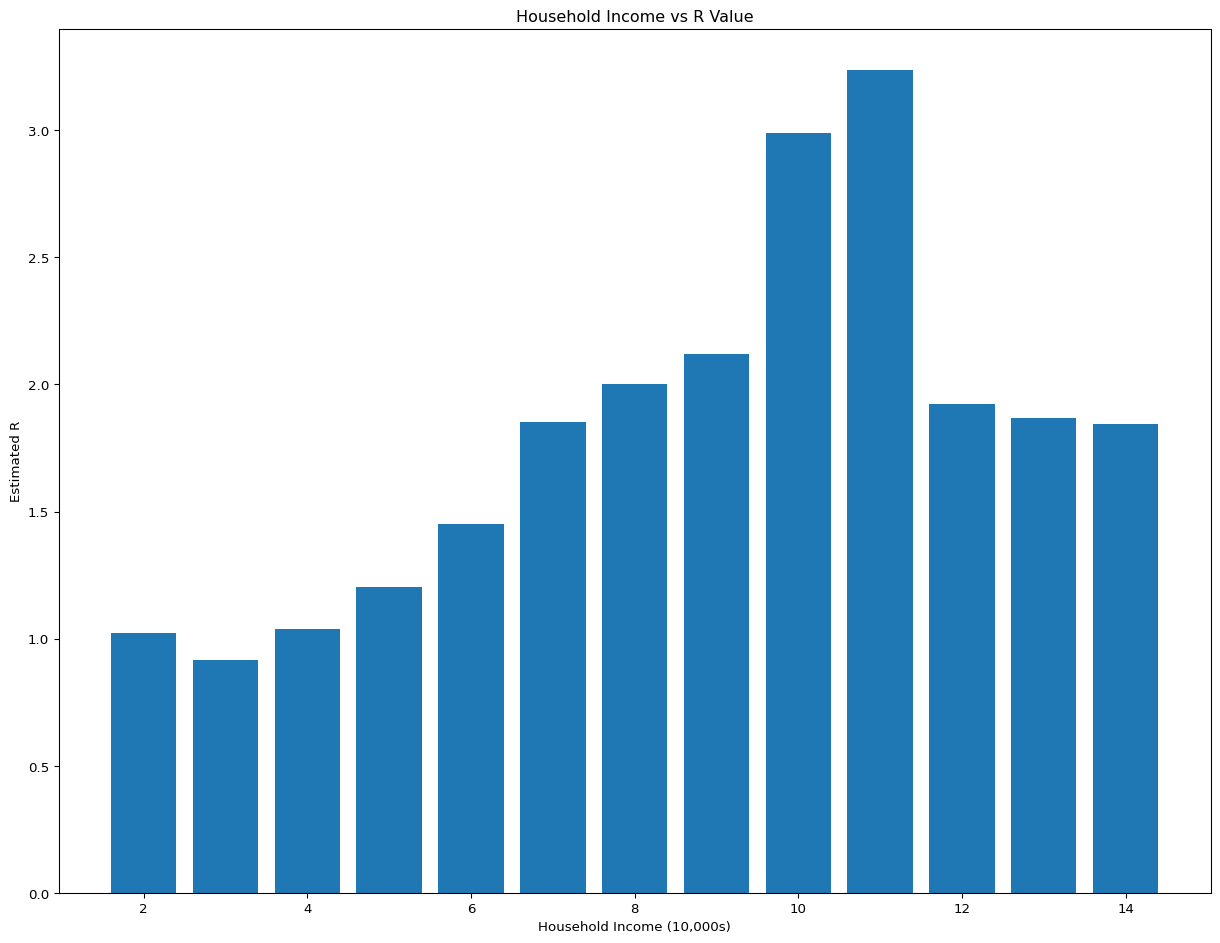

In [ ]:
income_data = scatter_data[["household_income", "estimated_r"]]
income_data["income_band"] = income_data["household_income"].apply(lambda x: int(x/10000))
print(income_data.head())
income_data = income_data.groupby("income_band").mean()["estimated_r"]
print(income_data)
fig = plt.figure(figsize=(12,9), dpi=96)
ax=fig.add_axes([0,0,1,1])
plt.bar(income_data.index.values, income_data)
ax.set_xlabel('Household Income (10,000s)')
ax.set_ylabel('Estimated R')
ax.set_title('Household Income vs R Value')
plt.show()


Text(0.5, 1.0, 'Population Density Rank vs R Value')

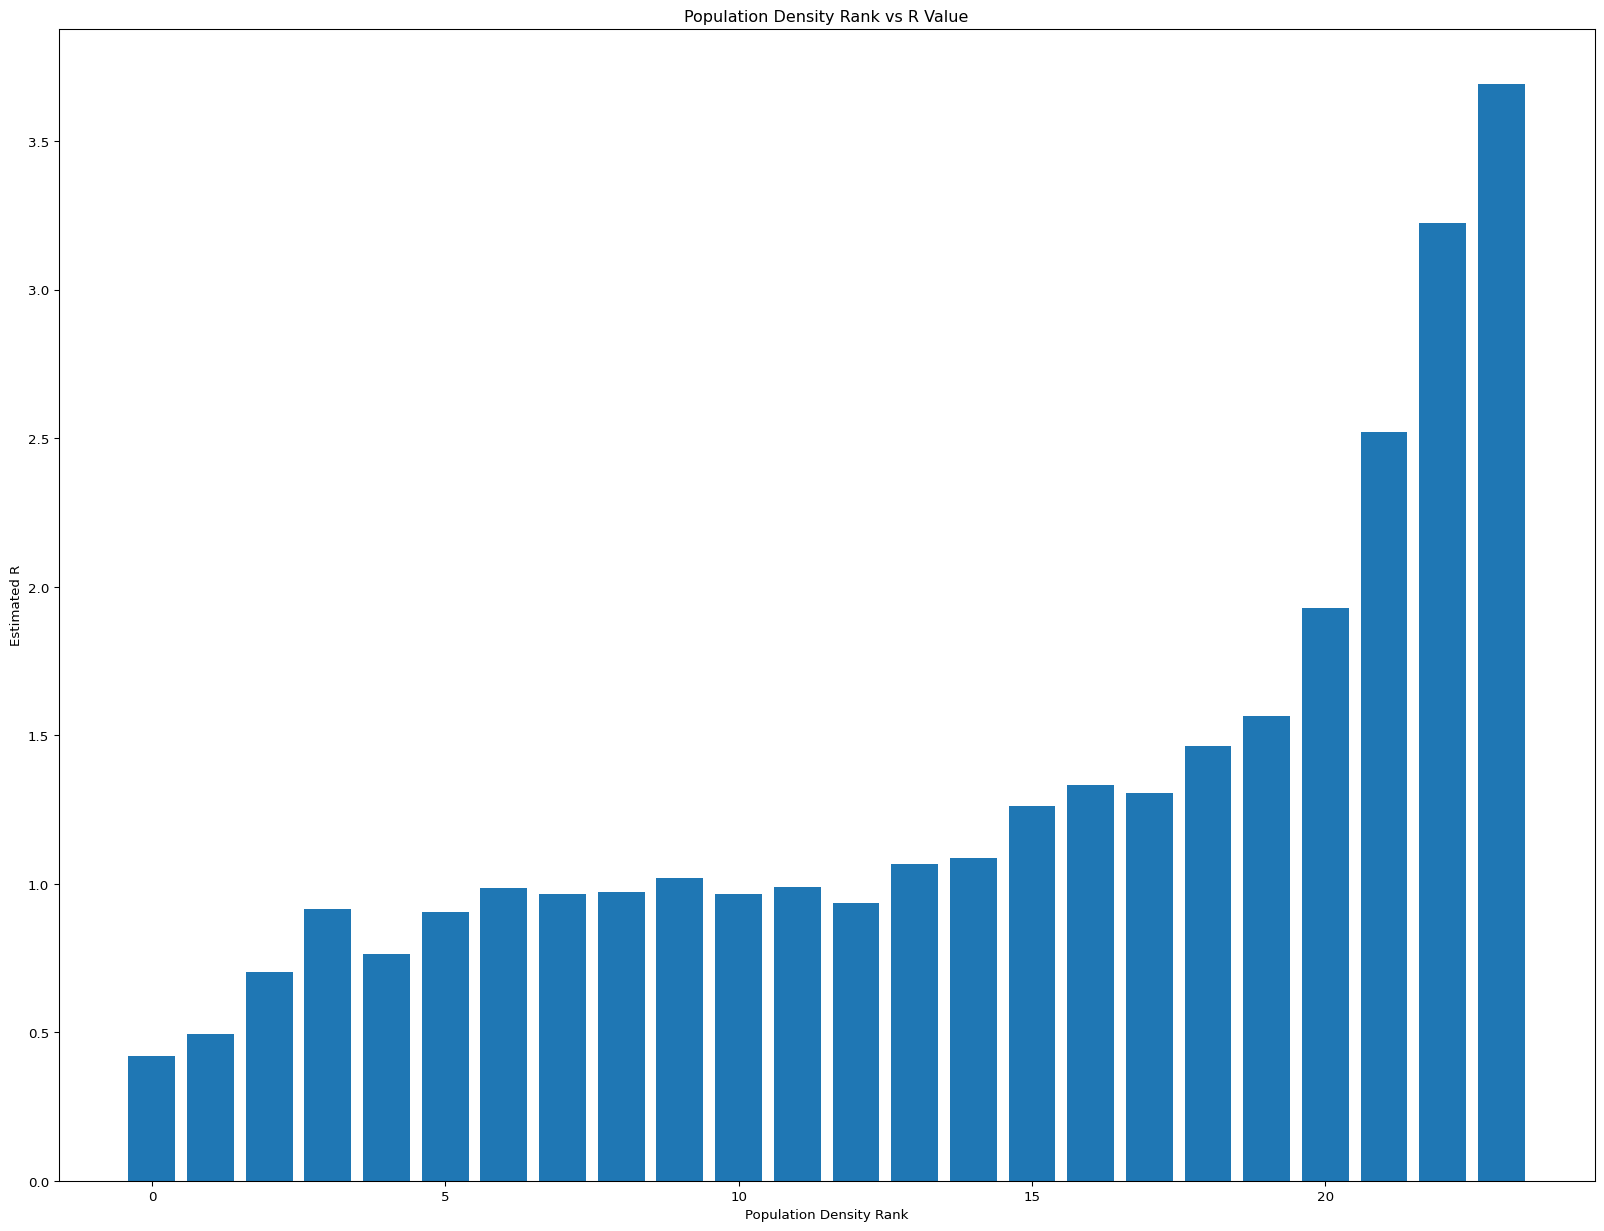

In [ ]:
density_data = scatter_data[["population_density", "estimated_r"]].sort_values(by="population_density").reset_index().reset_index()
#print(density_data)
density_data["rank_density"] = density_data["index"].apply(lambda x: int(x/128))
density_data = density_data.groupby("rank_density").mean()
#print(density_data) #gives rank density values from 0 to 22
fig=plt.figure(figsize=(16,12), dpi=96)
ax=fig.add_axes([0,0,1,1])
plt.bar(density_data.index.values, density_data["estimated_r"])
ax.set_xlabel('Population Density Rank')
ax.set_ylabel('Estimated R')
ax.set_title('Population Density Rank vs R Value')

In [ ]:
data = fips_final.reset_index()
date_threshold = datetime(year=2020, month=6, day=1)
train_data = data[data["date"] < date_threshold]
test_data = data[data["date"] >= date_threshold]
train_y = train_data["estimated_r"]
test_y = test_data["estimated_r"]
train_x = train_data[["household_income", "population_density", "days_spreading"]]
#train_data.head()
test_x = test_data[["household_income", "population_density", "days_spreading"]]
print(len(train_x), len(train_y), len(test_x), len(test_y))


163051 163051 29437 29437


In [ ]:
lr = LinearRegression()
lr.fit(train_x, train_y)
predictions = lr.predict(test_x)
print(mean_absolute_error(test_y, predictions))


1.5663141767905013


In [ ]:
clf = RandomForestRegressor(n_estimators=40)
clf.fit(train_x, train_y)
predictions = clf.predict(test_x)
print(mean_absolute_error(test_y, predictions))

0.24289861898845316


In [ ]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=0.5)
clf.fit(train_x, train_y)
predictions = clf.predict(test_x)
print(mean_absolute_error(test_y, predictions))


1.566314154233014


In [ ]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=20000,hidden_layer_sizes=(128,64,32,16,8,4,2,1))
regr.fit(train_x, train_y)
predictions = regr.predict(test_x)
print(mean_absolute_error(test_y, predictions))


1.2915264994595006


In [ ]:
from sklearn.linear_model import BayesianRidge
clf_poly = BayesianRidge()
clf_poly.fit(train_x,train_y)
predictions = clf_poly.predict(test_x)
print(mean_absolute_error(test_y, predictions))


1.565792526012258
